In [13]:
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import smopy
%matplotlib inline

#import data file
df = pd.read_csv('Calgary_Public_Library_Locations_and_Hours.csv')

#data file contains name of library, postal code, square_feet, phone_nmber, business hours (monday to sunday), and adress, which includes GPS coordinates 
#print(df)

#We can select the column of interest 
#For instance, to select the posta code, in column 2
post_code = df[df.columns[1:]]
#print(post_code)


#or to select the library names
#Now to select the library names
library_names = df[ df.columns[0] ]
#print(library_names)

#For this exercise we need the last column, which contains latitud and longitud of each location
#in pandas there are different ways to extract data of columns

#opc_1
loc_opc1 = df.ix[:,-2] 
#print(type(loc_opc1))

#or opc_2
loc_opc2 = df[ df.columns[-2]]
#print(type(loc_opc2))

address = df.Address.str.split('\n+\(|\)')


loc = []
for index in range(len(address)):
	loc.append(address[index][1].split(','))
	#print(address[index][1])

lat = []
lon = []
new_loc = []

for i in loc:
	lat.append(float(i[0]))
	lon.append(float(i[1]))

	new_loc.append( (float(i[0]) ,float(i[1]) ) )



box = [min(lat), min(lon), max(lat), max(lon)]

print(box)




[50.8986015, -114.1926956, 51.159462, -113.9485092]


In [17]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

Lowered zoom level to keep map size reasonable. (z = 11)


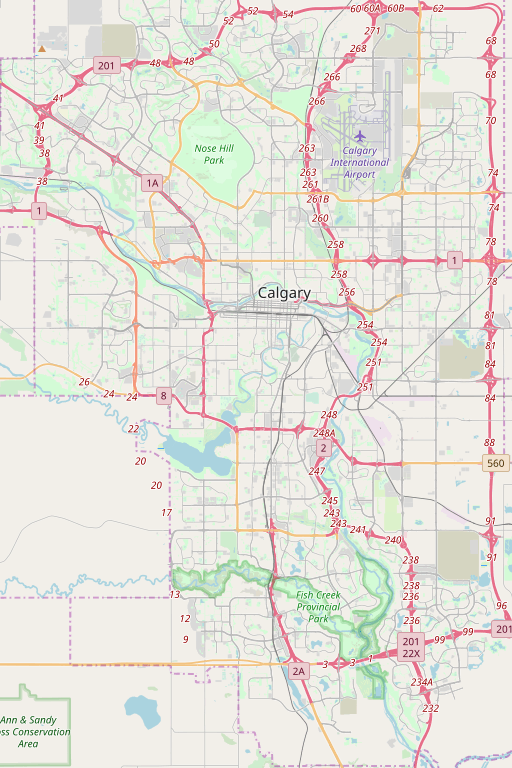

In [63]:
m = smopy.Map(box, z=12) #len(address))
m.show_ipython()

In [65]:
print(new_loc)

vor = spatial.Voronoi(new_loc)

[(51.0470276, -114.0578995), (51.0255318, -114.0947876), (51.0872841, -114.1830978), (50.9516296, -114.0603409), (51.045105, -113.9652023), (50.9835968, -114.0141449), (51.0652428, -114.1038132), (51.0412674, -114.0683823), (51.0960922, -114.1391296), (50.8986015, -114.062851), (51.0181122, -114.1756439), (50.963623, -114.0860367), (51.1121979, -114.0633087), (51.0753708, -113.9525833), (51.1295815, -114.1926956), (51.159462, -114.0675659), (51.1196709, -113.9485092), (51.0404778, -114.138237)]


In [66]:
regions, vertices = voronoi_finite_polygons_2d(vor)

In [67]:
faces = [m.to_pixels(vertices[region]) for region in regions]

In [69]:
cmap = plt.cm.Pastel1
cuadrants = 7


colors_by_face = cmap( np.linspace(0, 1, cuadrants))[:,3]

colors = .25 * np.ones((len(address)+1, 3))

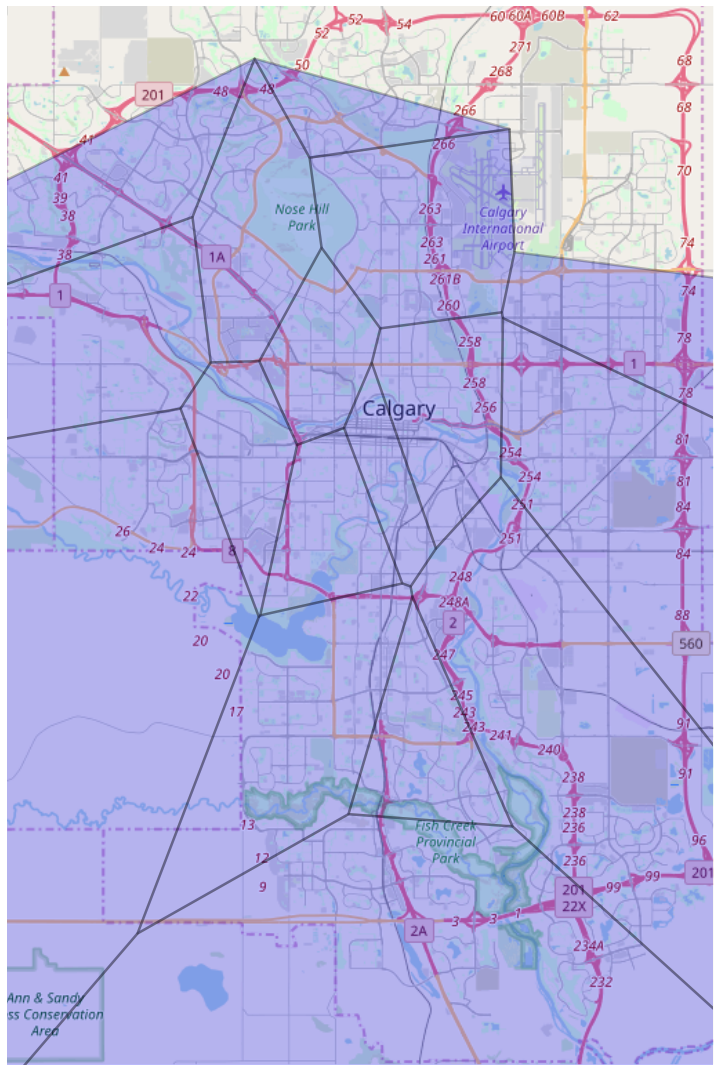

In [62]:
ax = m.show_mpl(figsize=(15,15))
ax.add_collection( mpl.collections.PolyCollection(faces, edgecolors='k', alpha=0.25, linewidth=2.5))